In [2]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap

# import geopandas as gpd
# from shapely.geometry  import Point
# from shapely.geometry import shape
# import seaborn as sns
from matplotlib.patches import Rectangle
import geopandas as gpd
from shapely.geometry  import Point
from shapely.geometry import shape


import pandas as pd 


# defs

## other functions

In [3]:
def create_mask(fo,lat_obs_cru,lon_obs_cru,buffer=0,plot=0):
  filename=gpd.read_file(fo)
  shp_geom = shape(filename.geometry[0])

  xxc, yyc = meshgrid(lon_obs_cru,lat_obs_cru)
  mask_shape=np.zeros(xxc.shape,dtype=bool)
  if plot==1:
    x,y = shp_geom.exterior.xy
    plt.plot(x,y)
  N1=xxc.shape[0]
  N2=xxc.shape[1]

  for lat_i in range(0,N1):
    for lon_i in range(0,N2):
      xi=xxc[lat_i,lon_i]
      yi=yyc[lat_i,lon_i]
      m1= (shp_geom.contains(Point(xi, yi)) or shp_geom.touches(Point(xi, yi)))
      mask_shape[lat_i,lon_i]=not m1

  return mask_shape

# init

In [4]:
gcm_names=['MIROC_ESM','CanESM2','HadGEM2_AO','GFDL_CM3']
gcm_iter=1
gcm_name=gcm_names[gcm_iter]
gcm_name
data_plot_all = []

##  Bias 

In [5]:
path_US_T='/home/vikram/BCSD_data/US_T_BCSD/'
path_US_P='/home/vikram/BCSD_data/US_P_BCSD/'

metadata=np.load(path_US_T + '/tas_metadata'+gcm_names[gcm_iter]+'.npy', allow_pickle=True)
lat_obs_us=metadata.item()['lat_obs']
lon_obs_us=metadata.item()['lon_obs']
lat_gcm_1=metadata.item()['lat_gcm']
lon_gcm_1=metadata.item()['lon_gcm']

mask_fine_us=create_mask('/home/vikram/BCSD_Shapefiles/us_rough.shp',lat_obs_us.data,lon_obs_us.data-360,buffer=0,plot=0)

tas_obs=np.load(path_US_T + '/tas_obs.npy')
tas_gcmf=np.load(path_US_T + '/tas_gcm_fine_'+gcm_names[gcm_iter]+'.npy')
tas_bcsd=np.load(path_US_T + '/BCSD_outputs_tas_'+gcm_names[gcm_iter]+'_cru.npy')


bias= tas_obs - tas_gcmf
correction =tas_bcsd  -tas_obs

data_plot_all.append(bias)
data_plot_all.append(correction)


In [6]:
metadata=np.load(path_US_P+'/pre_metadata'+gcm_names[gcm_iter]+'.npy', allow_pickle=True)
lat_obs_us=metadata.item()['lat_obs']
lon_obs_us=metadata.item()['lon_obs']
lat_gcm_1=metadata.item()['lat_gcm']
lon_gcm_1=metadata.item()['lon_gcm']

pre_obs=np.load(path_US_P+'/pre_obs.npy')
pre_gcmf=np.load(path_US_P+'/pre_gcm_fine'+gcm_names[gcm_iter]+'.npy')
pre_bcsd=np.load(path_US_P+'/BCSD_outputs_pre_'+gcm_names[gcm_iter]+'_cru.npy')

bias= pre_obs - pre_gcmf
correction = pre_bcsd -pre_obs

data_plot_all.append(bias)
data_plot_all.append(correction)



In [7]:
path_out ='/home/vikram/BCSD_data/India_T_BCSDd/'
gcm_meta_01=(np.load(path_out + '/bcsd_imd_metadata_'+gcm_name+'.npy',
                     allow_pickle=True)).item()
start_index = gcm_meta_01['Nyears_train']*365
imd=uu.correct_nan_inf_neg(np.load(path_out + '/data_obs_imd_pred.npy'))[start_index:]
gcm_01=uu.correct_nan_inf_neg(np.load(path_out + '/data_gcm_'+gcm_name+'_imd_pred.npy'))[start_index:]
out_id='tas_'+gcm_name
bcsd_gcm_01=uu.correct_nan_inf_neg(np.load(path_out + '/BCSD_outputs_'+out_id+'.npy'))[start_index:]

lat_obs_in_t=gcm_meta_01['lat_obs']
lon_obs_in_t=gcm_meta_01['lon_obs']
lat_gcm_01_t=gcm_meta_01['lat_gcm']
lon_gcm_01_t=gcm_meta_01['lon_gcm']

data_gf=np.zeros(imd.shape)
for i in range(gcm_01.shape[0]):
  data_gf[i,:,:]=uu.regrid(gcm_01[i,:,:],lat_gcm_01_t,lon_gcm_01_t,lat_obs_in_t,lon_obs_in_t)

bias= imd - data_gf
correction = bcsd_gcm_01 -imd

data_plot_all.append(bias)
data_plot_all.append(correction)
mask_fine_india_t = gcm_meta_01['mask']

In [8]:
bias.shape,start_index
gcm_meta_01['Nyears_train']*365

9125

In [9]:
path_out ='/home/vikram/BCSD_data/India_P_BCSDd/'
gcm_meta_01=(np.load(path_out + '/bcsd_imd_metadata_'+gcm_name+'.npy',
                     allow_pickle=True)).item()
start_index = gcm_meta_01['Nyears_train']*365

imd_pre=uu.correct_nan_inf_neg(np.load(path_out + '/data_obs_imd_pred.npy'))[start_index:]

gcm_01=uu.correct_nan_inf_neg(np.load(path_out + '/data_gcm_'+gcm_name+'_imd_pred.npy'))[start_index:]
out_id='pre_'+gcm_name
bcsd_gcm_01=uu.correct_nan_inf_neg(np.load(path_out + '/BCSD_outputs_'+out_id+'.npy'))[start_index:]

lat_obs_in=gcm_meta_01['lat_obs']
lon_obs_in=gcm_meta_01['lon_obs']
lat_gcm_01=gcm_meta_01['lat_gcm']
lon_gcm_01=gcm_meta_01['lon_gcm']
data_gf=np.zeros(imd_pre.shape)
for i in range(gcm_01.shape[0]):
  data_gf[i,:,:]=uu.regrid(gcm_01[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs_in,lon_obs_in)

bias= imd_pre - data_gf
correction = bcsd_gcm_01 -imd_pre

data_plot_all.append(bias)
data_plot_all.append(correction)
mask_fine_india = gcm_meta_01['mask']


In [10]:
data_plot_all[7].shape
bias.shape

(20075, 33, 35)

# Plot

In [11]:
from matplotlib.patches import Rectangle
data_plot_all[0].shape

(1260, 52, 112)

(260.25, 36.75)
(260.25, 36.75)
(260.25, 36.75)
(260.25, 36.75)


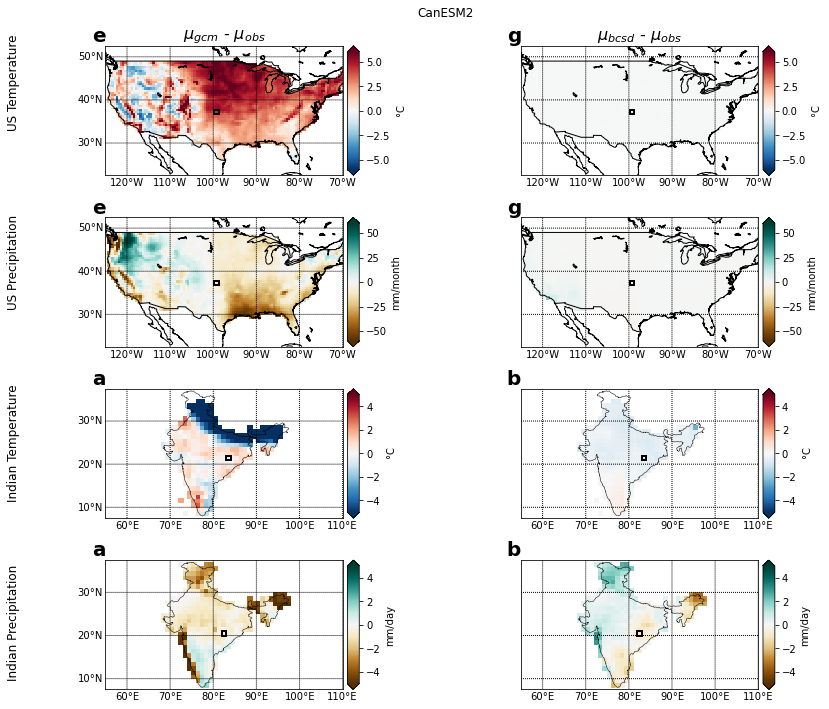

In [23]:
grid_us_lat_iter,grid_us_lon_iter  = 25 , 52
grid_india_lat_iter,grid_india_lon_iter = 14,16

data_plot=data_plot_all

pan_titles = ['e','g','e','g','a','b','a','b']
cmaps = ['RdBu_r','RdBu_r','BrBG','BrBG','RdBu_r','RdBu_r','BrBG','BrBG',]
titles_plot=[
             '$\mu_{gcm}$ - $\mu_{obs}$','$\mu_{bcsd}$ - $\mu_{obs}$',
             '$\mu_{gcm}$ - $\mu_{obs}$','$\mu_{bcsd}$ - $\mu_{obs}$',
             '$\mu_{gcm}$ - $\mu_{obs}$','$\mu_{bcsd}$ - $\mu_{obs}$',
             '$\mu_{gcm}$ - $\mu_{obs}$','$\mu_{bcsd}$ - $\mu_{obs}$',
             ]

clab_plot=['$\degree$C','$\degree$C','mm/month','mm/month','$\degree$C','$\degree$C','mm/day','mm/day']

masks=[mask_fine_us,mask_fine_us,mask_fine_us,mask_fine_us,mask_fine_india_t,mask_fine_india_t,mask_fine_india,mask_fine_india]

clims=[[-6,6],[-6,6],[-60,60],[-60,60],[-5,5],[-5,5],[-5,5],[-5,5]]

fig=plt.figure(figsize=(12,10))

for siter in range(8):
  if siter<4:
    lat_box=uu.cen_to_box(lat_obs_us)
    lon_box=uu.cen_to_box(lon_obs_us)
    rhx=lon_obs_us[grid_us_lon_iter+2]-lon_obs_us[grid_us_lon_iter]
    rhy=lat_obs_us[grid_us_lat_iter+2]-lat_obs_us[grid_us_lat_iter]    
    ll=(lon_obs_us[grid_us_lon_iter]-0.5*rhx,lat_obs_us[grid_us_lat_iter]-0.5*rhy)
    print(ll)
    mp_spacing=10
    map_bounds=[360-125,52.5,360-70,22.5]
    shape_bound='/home/vikram/BCSD_Shapefiles/us_rough'
  elif siter<6:

    
    lat_box=uu.cen_to_box(lat_obs_in_t)
    lon_box=uu.cen_to_box(lon_obs_in_t)
    
    rhx=lon_obs_in_t[grid_india_lon_iter+1]-lon_obs_in_t[grid_india_lon_iter]
    rhy=lat_obs_in_t[grid_india_lat_iter+1]-lat_obs_in_t[grid_india_lat_iter]
    ll=(lon_obs_in_t[grid_india_lon_iter]-0.5*rhx,lat_obs_in_t[grid_india_lat_iter]-0.5*rhy)

    mp_spacing=10
    map_bounds=[55,37.5,110,7.5]
    shape_bound='/home/vikram/BCSD_Shapefiles/ind'
  else:

    
    lat_box=uu.cen_to_box(lat_obs_in)
    lon_box=uu.cen_to_box(lon_obs_in)
    
    rhx=lon_obs_in[grid_india_lon_iter+1]-lon_obs_in[grid_india_lon_iter]
    rhy=lat_obs_in[grid_india_lat_iter+1]-lat_obs_in[grid_india_lat_iter]
    ll=(lon_obs_in[grid_india_lon_iter]-0.5*rhx,lat_obs_in[grid_india_lat_iter]-0.5*rhy)

    mp_spacing=10
    map_bounds=[55,37.5,110,7.5]
    shape_bound='/home/vikram/BCSD_Shapefiles/ind'

  axx=plt.subplot(4,2,siter+1)

  data_x=ma.MaskedArray(np.nanmean(data_plot[siter],axis=0),mask=masks[siter])

  map = Basemap(projection='cyl',resolution='l',
                llcrnrlon=map_bounds[0], 
                urcrnrlat=map_bounds[1],
                urcrnrlon=map_bounds[2], 
                llcrnrlat=map_bounds[3])

  xx, yy = meshgrid(lon_box,lat_box )
  map.pcolor(xx, yy, -data_x,cmap=cmaps[siter])
  map.drawmeridians(np.arange(-180,180,mp_spacing),labels=[0,0,0,1], linewidth=1.0) #longitudes
  map.drawparallels(np.arange(-90,90,mp_spacing),labels=[(1+siter)%2,0,0,0], linewidth=1.0) #latitudes
  cbar = map.colorbar(extend='both')
  cbar.set_label(clab_plot[siter], rotation=90)
  plt.clim(clims[siter])

  rect1 = Rectangle(ll, rhx, rhy, facecolor='none',edgecolor='black' )
  pt1=axx.add_patch(rect1) 
  pt1.zorder=1
  pt1.set_lw(2)
  if siter<4:
    map.drawcountries(linewidth=1)
    map.drawcoastlines(linewidth=1)
  else:
    map.readshapefile(shape_bound,'DD',drawbounds=True)
    # pass

  #map.drawcoastlines(linewidth=1)
  if siter<2:
    plt.title(titles_plot[siter],fontsize=16)
  plt.text(0, 1, pan_titles[siter], horizontalalignment='right',verticalalignment='bottom', transform=axx.transAxes,fontweight=800,
            fontsize=20,color='k')


fig.text(0.0, 0.875, 'US Temperature', ha='center',va='center', rotation='vertical', fontsize=12)
fig.text(0.0, 0.625, 'US Precipitation', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.0, 0.375, 'Indian Temperature', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.0, 0.125, 'Indian Precipitation', ha='center', va='center', rotation='vertical', fontsize=12)

fig.suptitle(gcm_name)
plt.tight_layout()
plt.savefig('./bias_and_change_'+gcm_name+'.svg')

# Correction Characteristics

## ACF and distribution

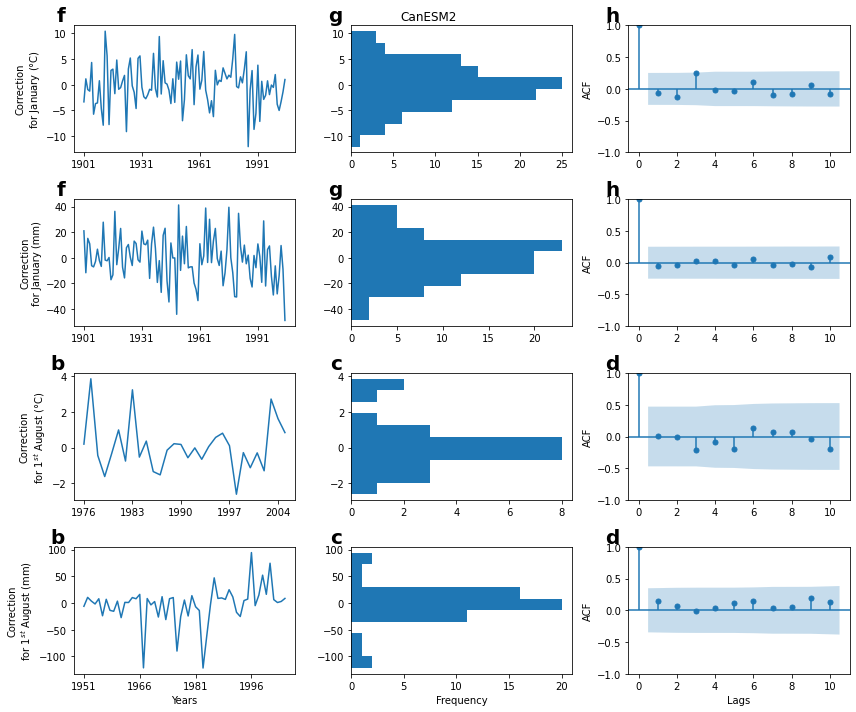

In [24]:

pan_titles = ['c','d','e',
              'c','d','e',
              'h','i','j',
              'h','i','j']
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig = plt.figure(figsize=(12,10))
lxx =-0.04
lyy=1
i,j=grid_us_lat_iter,grid_us_lon_iter
x=data_plot_all[1][::12,i,j]

ax = plt.subplot(4,3,1)
plt.plot(x)
plt.ylabel("Correction\nfor January ($\degree$C)")
plt.xticks(range(0,105,30),range(1901,2005,30))
#plt.xlabel('Years')
plt.text(lxx, lyy, 'f', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')

ax = plt.subplot(4,3,2)
plt.hist(x, orientation='horizontal')
#plt.xlabel('Frequency')
plt.text(lxx, lyy, 'g', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')

ax=plt.subplot(4,3,3)
sm.graphics.tsa.plot_acf(x, lags=10,alpha=0.01,ax=ax,title="")
#plt.xlabel('Lags')
plt.ylabel('ACF')
plt.text(lxx, lyy, 'h', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')



i,j=grid_us_lat_iter,grid_us_lon_iter
x=data_plot_all[3][::12,i,j]

ax = plt.subplot(4,3,4)
plt.plot(x)
plt.ylabel("Correction\nfor January (mm)")
plt.xticks(range(0,105,30),range(1901,2005,30))
#plt.xlabel('Years')
plt.text(lxx, lyy, 'f', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')

ax = plt.subplot(4,3,5)
plt.hist(x, orientation='horizontal')
#plt.xlabel('Frequency')
plt.text(lxx, lyy, 'g', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')

ax=plt.subplot(4,3,6)
sm.graphics.tsa.plot_acf(x, lags=10,alpha=0.01,ax=ax,title="")
#plt.xlabel('Lags')
plt.ylabel('ACF')
plt.text(lxx, lyy, 'h', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')


i,j=grid_india_lat_iter,grid_india_lon_iter
x=data_plot_all[5][213::365,i,j]
ax = plt.subplot(4,3,7)
plt.plot(x)
plt.ylabel("Correction\nfor $1^{st}$ August ($\degree$C)")
plt.xticks(range(0,30,7),range(1976,2005,7))
plt.text(lxx, lyy, 'b', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')

ax = plt.subplot(4,3,8)
plt.hist(x, orientation='horizontal')
plt.text(lxx, lyy, 'c', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')

ax=plt.subplot(4,3,9)
sm.graphics.tsa.plot_acf(x, lags=10,alpha=0.01,ax=ax,title="")
plt.ylabel('ACF')
plt.text(lxx, lyy, 'd', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')



i,j=grid_india_lat_iter,grid_india_lon_iter
x=data_plot_all[7][213::365,i,j]

ax = plt.subplot(4,3,10)
plt.plot(x)
plt.ylabel("Correction\nfor $1^{st}$ August (mm)")
plt.xticks(range(0,55,15),range(1951,2005,15))
plt.xlabel('Years')
plt.text(lxx, lyy, 'b', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')


ax = plt.subplot(4,3,11)
plt.hist(x, orientation='horizontal')
plt.xlabel('Frequency')
plt.text(lxx, lyy, 'c', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')

ax=plt.subplot(4,3,12)
sm.graphics.tsa.plot_acf(x, lags=10,alpha=0.01,ax=ax,title="")
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.text(lxx, lyy, 'd', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')



# 
plt.tight_layout()

plt.suptitle(gcm_name)

plt.savefig('./ts_dist_acf_'+gcm_name+'.svg')
